useful links:
- https://keras.io/api/layers/preprocessing_layers/image_augmentation/

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import keras
import pandas as pd
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ["KERAS_BACKEND"] = "tensorflow"
seed = 42 # for testability purposes
keras.utils.set_random_seed(seed)
np.random.seed(seed)

2026-01-13 10:35:54.539098: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/enrico/ComputerVision/.venv/lib/python3.12/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [2]:
def size_to_change(img, size):
    if img.shape[0] <= img.shape[1]:
        return (256, int(np.floor(256 / img.shape[0] * img.shape[1])))
    else:
        return (int(np.floor(256 / img.shape[1] * img.shape[0])), 256)

def load_data(url_directory, url_file, size=256, crop_dim=224, random_crop=False, central_crop=False, return_original=False):
    X = []
    y = []
    X_original = []
    
    with open(url_directory + url_file) as f:
        for line in f:
            line_split = line.split(",")
            img = cv2.imread(url_directory + line_split[0])
            img_resized = cv2.resize(img, size_to_change(img, size))
            lbl = int(line_split[2].strip())

            if random_crop:
                crop = get_random_crop(img_resized, crop_dim, crop_dim) # is it fine even for val and test?
            elif central_crop: # center crop
                img_center = (img_resized.shape[0] // 2, img_resized.shape[1] // 2)
                crop_dim_half = crop_dim // 2
                crop = img_resized[
                    img_center[0] - crop_dim_half : img_center[0] - crop_dim_half + crop_dim,
                    img_center[1] - crop_dim_half : img_center[1] - crop_dim_half + crop_dim
                    ]
            else:
                crop = img_resized[:crop_dim, :crop_dim]

            X.append(crop)
            y.append(lbl)

            if return_original:
                img_resized_original = img_resized[:size, :size]
                X_original.append(img_resized_original)

    X = np.stack(X, axis=0)
    y = np.array(y)

    if return_original:
        return X, y, np.stack(X_original, axis=0)
    else:
        return X, y

In [3]:
url_directory = "../GroceryStoreDataset/dataset/"

X_train = []
y_train = []

X_train, y_train = load_data(url_directory, "train.txt")
X_val, y_val = load_data(url_directory, "val.txt")
X_test, y_test = load_data(url_directory, "test.txt")

In [4]:
df_classes = pd.read_csv(url_directory + "classes.csv")
df_coarse = df_classes.loc[:, ['Coarse Class Name (str)', 'Coarse Class ID (int)']].drop_duplicates().values
labels_coarse = {i: lbl for lbl, i in df_coarse}
n_classes_coarse = len(labels_coarse)

#### MODEL BUILDING

In [5]:
from keras import Sequential
from keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, Rescaling, RandomColorJitter, RandomCrop, RandomErasing,\
    RandomFlip, RandomRotation, RandomZoom, RandomTranslation

input_shape = X_train.shape[1:]
#crop_dim = 224

model = Sequential(
    [   
        # Input layer.
        Input(shape=input_shape),
        
        # Data Augmentation
        #RandomCrop(height=224, width=224),
        RandomFlip(mode='horizontal'),
        RandomRotation(factor=0.2),
        RandomZoom(height_factor=0.2, width_factor=0.2),
        RandomTranslation(height_factor=0.1, width_factor=0.1),
        RandomColorJitter(brightness_factor=(0.8, 1.2), contrast_factor=(0.8, 1.2), saturation_factor=(0.8, 1.2)),
        RandomErasing(factor=0.2, fill_value='random'),

        # Data Normalisation
        Rescaling(1./255),

        # Convolutions with subsequent pooling.
        Conv2D(filters = 32, kernel_size = (3, 3), activation = "relu", padding = 'same'),
        MaxPooling2D(pool_size = (2, 2)),
        Conv2D(filters = 64, kernel_size = (3, 3), activation = "relu", padding = 'same'),
        MaxPooling2D(pool_size = (2, 2)),

        # Other Convolutions
        Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'),
        MaxPooling2D(pool_size = (2, 2)),
        Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'),
        MaxPooling2D(pool_size = (2, 2)),
        Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'),
        MaxPooling2D(pool_size = (2, 2)),

        # Classification head.
        Flatten(),
        Dense(units = n_classes_coarse, activation = "softmax")
    ]
)

model.summary()

2026-01-13 10:36:01.862350: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2026-01-13 10:36:01.862393: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:160] env: CUDA_VISIBLE_DEVICES="-1"
2026-01-13 10:36:01.862400: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:163] CUDA_VISIBLE_DEVICES is set to -1 - this hides all GPUs from CUDA
2026-01-13 10:36:01.862403: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:171] verbose logging is disabled. Rerun with verbose logging (usually --v=1 or --vmodule=cuda_diagnostics=1) to get more diagnostic output from this module
2026-01-13 10:36:01.862408: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:176] retrieving CUDA diagnostic information for host: acer
2026-01-13 10:36:01.862412: I external/local_xla/xla/stream_executor/cuda/cuda_dia

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip (RandomFlip)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation                 │ (None, 224, 224, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom (RandomZoom)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_translation              │ (None, 224, 224, 3)    │             0 │
│ (RandomTranslation)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_color_jitter             │ (None, 224, 224, 3)    │             0 │
│ (RandomColorJitter)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_erasing (RandomErasing)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 43)             │     1,078,827 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,647,403 (10.10 MB)

 Trainable params: 2,647,403 (10.10 MB)

 Non-trainable params: 0 (0.00 B)

#### MODEL TRAINING

considerations:
- with 8 epochs -> underfitting (train accuracy ~0.31)

In [6]:
from keras.optimizers import Adam
from keras.losses import SparseCategoricalCrossentropy

opt = Adam(learning_rate = 1e-3)
loss_fcn = SparseCategoricalCrossentropy()
batch_size = 32 #128
epochs = 20 

model.compile(
    loss = loss_fcn,
    optimizer = opt, 
    metrics = ["accuracy"]
) 

model.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs = epochs, 
    validation_data = (X_val, y_val)
);

Epoch 1/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 217s 3s/step - accuracy: 0.1273 - loss: 3.3783 - val_accuracy: 0.1081 - val_loss: 3.2278
Epoch 2/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 207s 2s/step - accuracy: 0.1826 - loss: 3.0155 - val_accuracy: 0.1520 - val_loss: 2.9574
Epoch 3/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 199s 2s/step - accuracy: 0.2114 - loss: 2.7795 - val_accuracy: 0.1858 - val_loss: 2.8657
Epoch 4/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 200s 2s/step - accuracy: 0.2379 - loss: 2.6704 - val_accuracy: 0.2568 - val_loss: 2.7186
Epoch 5/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 201s 2s/step - accuracy: 0.2723 - loss: 2.5036 - val_accuracy: 0.1486 - val_loss: 3.1035
Epoch 6/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 201s 2s/step - accuracy: 0.2909 - loss: 2.4301 - val_accuracy: 0.2905 - val_loss: 2.4325
Epoch 7/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 201s 2s/step - accuracy: 0.3242 - loss: 2.2432 - val_accuracy: 0.2939 - val_loss: 2.4680
Epoch 8/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 208s 3s/step - accuracy: 0.3511 - loss: 2.1295 - val_accuracy: 0.2973 - v

#### MODEL EVALUATION

10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 279ms/step - accuracy: 0.4459 - loss: 2.0090
The test loss is 2.0090, the test accuracy is 0.4459.


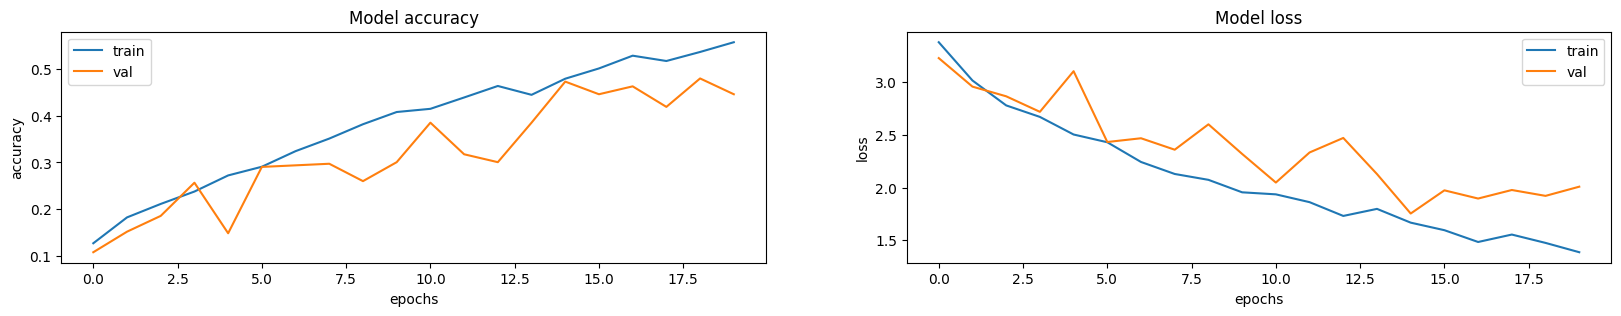

In [7]:
plt.figure(figsize=(20, 3))
for i, metric in enumerate(["accuracy", "loss"]):
    plt.subplot(1, 2, i + 1) 
    plt.plot(model.history.history[metric])
    plt.plot(model.history.history["val_" + metric])
    plt.title("Model {}".format(metric))
    plt.xlabel("epochs")
    plt.ylabel(metric)
    plt.legend(["train", "val"])

val_loss, val_metric = model.evaluate(X_val, y_val, verbose = 1)
print(f"The test loss is {val_loss:.4f}, the test accuracy is {val_metric:.4f}.")

In [8]:
test_loss, test_metric = model.evaluate(X_test, y_test, verbose = 1)
print(f"The test loss is {test_loss:.4f}, the test accuracy is {test_metric:.4f}.")

78/78 ━━━━━━━━━━━━━━━━━━━━ 22s 284ms/step - accuracy: 0.4885 - loss: 1.7511
The test loss is 1.7511, the test accuracy is 0.4885.
